# Multivariate Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from math import sqrt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data and Model Import

In [2]:
data = pd.read_csv('data/data.csv')

<ipython-input-2-e9bba6ebf1b5>:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/data.csv')


In [3]:
data['Clim_zone'] = data['Clim_zone'].astype('category')
data['Coastal?']  = data['Coastal?'].astype('category')

In [4]:
data = pd.concat([data, pd.get_dummies(data['Clim_zone'])], axis=1)

In [5]:
old_col = ['Albedo_Built', 'Albedo_Grass', 'Albedo_Tree', 'DEM_urb_CT_act']
new_col = ['Built Albedo', 'Grass Albedo', 'Tree Albedo', 'Elevation']
data.rename(columns=dict(zip(old_col, new_col)), inplace=True)

In [6]:
features = ['Built Area (%)', 'Grass Area (%)', 'Tree Area (%)', 
            #'Albedo_Built', 'Albedo_Grass', 'Albedo_Tree', 'DEM_urb_CT_act', 
            'Built Albedo', 'Grass Albedo', 'Tree Albedo', 'Elevation',
            'Coastal?', 'Arid', 'Snow', 'Temperate', 'Tropical']

In [7]:
labels = ['CUHI_day_summer', 'CUHI_night_summer', 'SUHI_day_summer', 'SUHI_night_summer']

## Helper Functions

In [8]:
def get_data(label):
    Xy = data[features+[label]].dropna().copy()
    X  = Xy.copy()[features]
    y  = Xy.copy()[label]
    
    X['Coastal?'] = X['Coastal?'].astype(int)
    return X, y

### Feature Importance
We provide feature importance of the linear regression coefficients by scaling the features. In order to do so, we use the technique proposed by Andrew Gelman, whereby we scale by two standard deviations as to not manipulate the binary variables, which provide an intuitive interpretation. 

$\frac{x-\mu_x}{2\sigma_x}$

Reference:
[Scaling regression inputs by dividing by two standard deviations](https://sites.stat.columbia.edu/gelman/research/published/standardizing7.pdf)

In [9]:
def transform(X):
    X_transform = X.copy()
    numeric_features = features[:-5]
    for feature in numeric_features:
        X_transform[feature] = (X_transform[feature] - X_transform[feature].mean()) / (2 * X_transform[feature].std())
        return X_transform

In [10]:
def get_model(X, y):
    X       = sm.add_constant(X)
    model   = sm.OLS(y, np.asarray(X))
    results = model.fit()
    
    return model, results

In [11]:
def save_results(results, label):
    summary = pd.DataFrame({'Features': ['Constant']+features, 'Coefficients': np.asarray(results.params), 
                           'LB': np.asarray(results.conf_int()[0]), 'UB': np.asarray(results.conf_int()[1]), 
                           'pval': np.asarray(results.pvalues)})
    summary = summary.round(4)
    summary.to_csv('tables/linear_regression/{}.csv'.format(label),index=False)
    return

## Multivariate Linear Regression

- Compute results summary for each label
- Create a graph of standardized effect and weighted effect for each label 

### Standard Model Results

In [12]:
for label in labels:
    X, y = get_data(label)
    model, results = get_model(X, y)
    save_results(results, label)
    print(label)
    print('R2: {:.3f}'.format(results.rsquared))
    print('RMSE: {:.3f}'.format(sqrt(results.mse_total)))

CUHI_day_summer
R2: 0.264
RMSE: 0.693
CUHI_night_summer
R2: 0.370
RMSE: 0.550
SUHI_day_summer
R2: 0.463
RMSE: 2.988
SUHI_night_summer
R2: 0.333
RMSE: 0.974


### Feature Importance for Linear Regression
Here, standardized provides us with comparable coefficients on the same scale so that we can glean variable importance from the linear model.

In [13]:
def weighted_effect(X_tranform, feat_imp):
    weighted_X = X_tranform.copy()
    weights    = feat_imp['Coefficients'].to_numpy()
    for i in range(len(features)):
        feature = features[i]
        weight  = weights[i] 
        weighted_X[feature] = weighted_X[feature] * weight
    return weighted_X

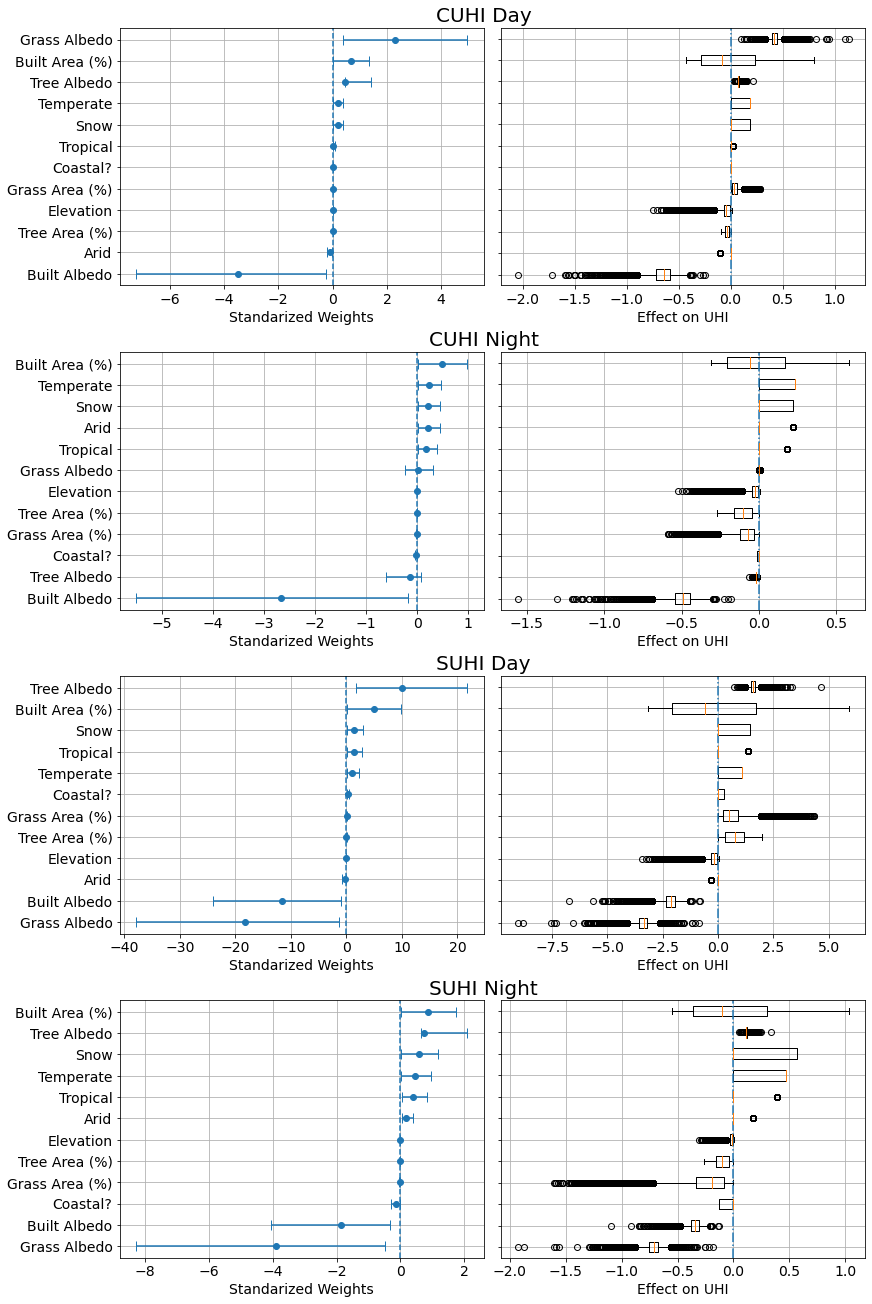

In [16]:
font = {'size': 14}
matplotlib.rc('font', **font)
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(12,18), constrained_layout=True)

for i in range(nrows):
    label = labels[i]
    X, y = get_data(label) # get data
    X = transform(X) # transform data
    model, results = get_model(X, y) # get model
    feat_imp = pd.DataFrame({'Features': features, 'Coefficients': np.asarray(results.params[1:]), 
                             'LB': np.asarray(results.conf_int()[0][1:]), 'UB': np.asarray(results.conf_int()[1][1:])})
    weighted_X = weighted_effect(X, feat_imp)
    feat_imp_sorted = feat_imp.sort_values(by='Coefficients', ascending=True)
    
    # Uneven confidence intervals (errors)
    lower_errors = feat_imp_sorted['LB'].to_numpy()
    upper_errors = feat_imp_sorted['UB'].to_numpy()

    # Asymmetric error values for plotting
    errors = [np.abs(lower_errors), np.abs(upper_errors)]

    # Create the plot with error bars
    ax[i][0].errorbar(np.asarray(feat_imp_sorted['Coefficients']), np.asarray(feat_imp_sorted['Features']), xerr=errors, fmt='o', capsize=5)
    ax[i][0].set_xlabel('Standarized Weights')
    ax[i][0].axvline(0, linestyle='dashed')
    ax[i][0].grid(True)

    ax[i][1].boxplot([weighted_X[feature].to_numpy() for feature in feat_imp_sorted['Features'].to_list()], vert=False)
    ax[i][1].axvline(0, linestyle='dashdot')
    ax[i][1].set_xlabel('Effect on UHI')
    ax[i][1].tick_params(labelleft=False) 
    ax[i][1].grid(True)

ax_titles = ['CUHI Day', 'CUHI Night', 'SUHI Day', 'SUHI Night']   
for i in range(nrows):
    ax[i][0].set_title(ax_titles[i], x=1, fontsize=20)
plt.savefig('graphs/variable_importance/linear_feature_importance.png', bbox_inches='tight', dpi=960)
